# Dependencies

In [1]:
###NLP package

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
sid = SentimentIntensityAnalyzer()

import spacy
import spacy_transformers
from spacy import displacy
from collections import Counter
import en_core_web_trf
nlp = en_core_web_trf.load()


###Transformer

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###Others
from ipynb.fs.full.News_Scraper import scrape_ticker_fv



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/filippog/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Today is  2021-10-20
['2021-10-19 10:42PM', ' American City Business Journals', "The #AppleToo organizer Apple just fired didn't expect to be terminated  but isn't sorry about speaking out"] 

['2021-10-19 03:06PM', " Investor's Business Daily", 'Dow Jones Gains As Apple Pops; Biden Makes Spending Move; Bitcoin ETF Jumps On Debut'] 

['2021-10-19 12:32PM', " Investor's Business Daily Video", 'Apple Reclaims Key Level'] 

['2021-10-19 12:20PM', ' Yahoo Finance Video', 'Apple debuts new MacBook Pros with M1 Pro and M1 Max chips'] 

['2021-10-19 11:39AM', ' Investopedia', 'Apple (AAPL) Is Early Phone Leader in Heated 5G Race'] 



# Encode text

In [2]:
###Download text
texts = [t[2] for t in scrape_ticker_fv('aapl', verbose = 0, filtering = 'apple')]

In [3]:

###Choose this embedding because it has small dimensionality. Good for clustering
embedder = SentenceTransformer('all-MiniLM-L12-v2')

# Corpus with example sentences
corpus = texts
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1.35, keepdims=True)



# Clustering

## Without PCA

Find optimal cluster width

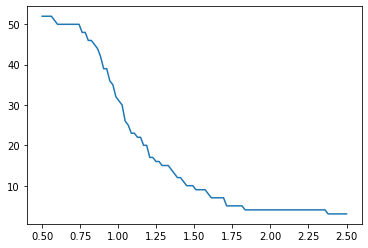

In [4]:
distance_ts = np.linspace(0.5, 2.5, 100)
num_cluster = []

for distance_t in distance_ts:
    # Perform kmean clustering
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_t) #, affinity='cosine', linkage='average', distance_threshold=0.4)
    clustering_model.fit(corpus_embeddings)
    cluster_assignment = clustering_model.labels_


    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(corpus[sentence_id])

    num_cluster.append( np.unique(cluster_assignment).shape[0])


plt.plot(distance_ts, num_cluster)
plt.show()



Cluster at optimal width

In [6]:
opt_distance = 2

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=opt_distance) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_


clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])


for i, cluster in clustered_sentences.items():
    score = 0
    for s in cluster:
        score += sid.polarity_scores(s)['compound']
    score = score/len(cluster)
    #print("Cluster ", i+1, "Score: ", score)
    print("Cluster ", i+1)
    for s in cluster:
        
        displacy.render(nlp(s), jupyter=True, style='ent')

    print("")



Cluster  4


/Users/filippog/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/spacy/displacy/__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)



Cluster  1



Cluster  3



Cluster  2


Reduce dimensionality and visualize

In [7]:
###Create colormap
import matplotlib
from matplotlib import colors
import seaborn as sns

#Choose the colormap you want to pick up colors from
source_cmap=matplotlib.cm.get_cmap('gist_rainbow')

#Choose number of colors and set a step
cols=len(list(clustered_sentences.items()));
step=1/float(cols - 1)

#Declare a vector to store given colors
cmap_vec=[]

#Run from 0 to 1 (limits of colormap)
#stepwise and pick up equidistant colors

for color in np.arange(0,1.1,step):
    #store color in vector
    cmap_vec.append( source_cmap(color) )

#Create colormap with chosen colors
    custom_cmap=\
    colors.ListedColormap([ color for color in cmap_vec ])



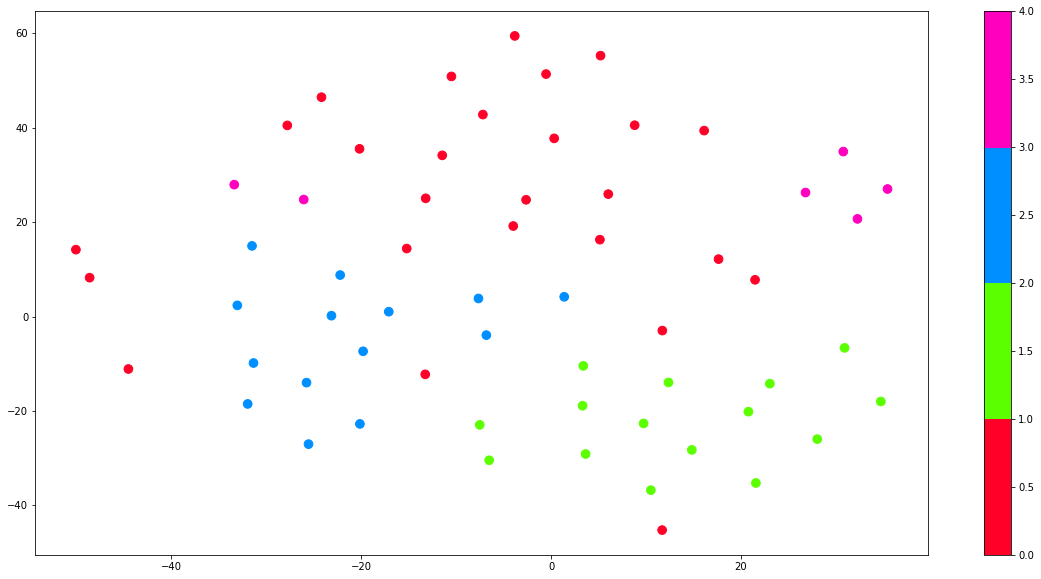

In [8]:
###Visualize
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(corpus_embeddings)
#print(cluster_assignment)
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
#outliers = result.loc[result.labels == -1, :]
#clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster_assignment, vmin = 0, vmax = cols, s=75, cmap=custom_cmap)
plt.colorbar()
plt.show()

Cluster keywords

In [9]:
for i, cluster in clustered_sentences.items():
    words = {}
    for s in cluster:
        lemmas = [y.lemma_ for y in nlp(s) if not y.is_stop and y.pos_ != 'PUNCT']
        for w in lemmas:
            try:
                words[w] += 1
            except Exception as e:
                words[w] = 1

    indices = np.argsort(list(words.values())).astype(int)
    keys_ = list(words.keys())
    #print(list(words.keys()))
    keywords = [keys_[int(ind)] for ind in indices[-5:]]
        
    print("Cluster ", i+1, "has keywords: ", keywords)
    print("")





Cluster  4 has keywords:  ['harassment', 'worker', 'movement', 'Apple', 'fire']

Cluster  1 has keywords:  ['5', 'Jones', 'Dow', 'apple', 'Apple']

Cluster  3 has keywords:  ['Pro', 'chip', 'M1', 'new', 'Apple']

Cluster  2 has keywords:  ['launch', 'chip', 'AirPods', 'new', 'Apple']



## With PCA

Find optimal cluster width

(62, 384)
(62, 50)


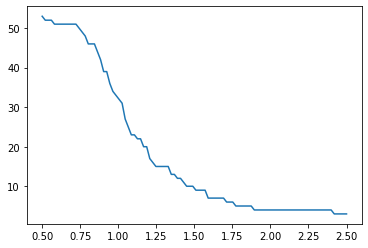

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
print(corpus_embeddings.shape)
embeddings_PCA = pca.fit_transform(corpus_embeddings)
print(embeddings_PCA.shape)

###Find optimal distance
distance_ts = np.linspace(0.5, 2.5, 100)
num_cluster = []
for distance_t in distance_ts:
    # Perform kmean clustering
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_t) #, affinity='cosine', linkage='average', distance_threshold=0.4)
    clustering_model.fit(embeddings_PCA)
    cluster_assignment = clustering_model.labels_


    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(corpus[sentence_id])

    num_cluster.append( np.unique(cluster_assignment).shape[0])


plt.plot(distance_ts, num_cluster)
plt.show()





Cluster at optimal width

In [64]:
opt_distance = 2

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=opt_distance) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_


clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])


for i, cluster in clustered_sentences.items():
    score = 0
    for s in cluster:
        score += sid.polarity_scores(s)['compound']
    score = score/len(cluster)
    #print("Cluster ", i+1, "Score: ", score)
    print("Cluster ", i+1)
    for s in cluster:
        
        displacy.render(nlp(s), jupyter=True, style='ent')

    print("")



Cluster  4


/Users/filippog/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/spacy/displacy/__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)



Cluster  1



Cluster  3



Cluster  2


Reduce dimensionality and visualize

In [75]:
###Create colormap
import matplotlib
from matplotlib import colors
import seaborn as sns

#Choose the colormap you want to pick up colors from
source_cmap=matplotlib.cm.get_cmap('gist_rainbow')

#Choose number of colors and set a step
cols=len(list(clustered_sentences.items()));
step=1/float(cols - 1)

#Declare a vector to store given colors
cmap_vec=[]

#Run from 0 to 1 (limits of colormap)
#stepwise and pick up equidistant colors

for color in np.arange(0,1.1,step):
    #store color in vector
    cmap_vec.append( source_cmap(color) )

#Create colormap with chosen colors
    custom_cmap=\
    colors.ListedColormap([ color for color in cmap_vec ])



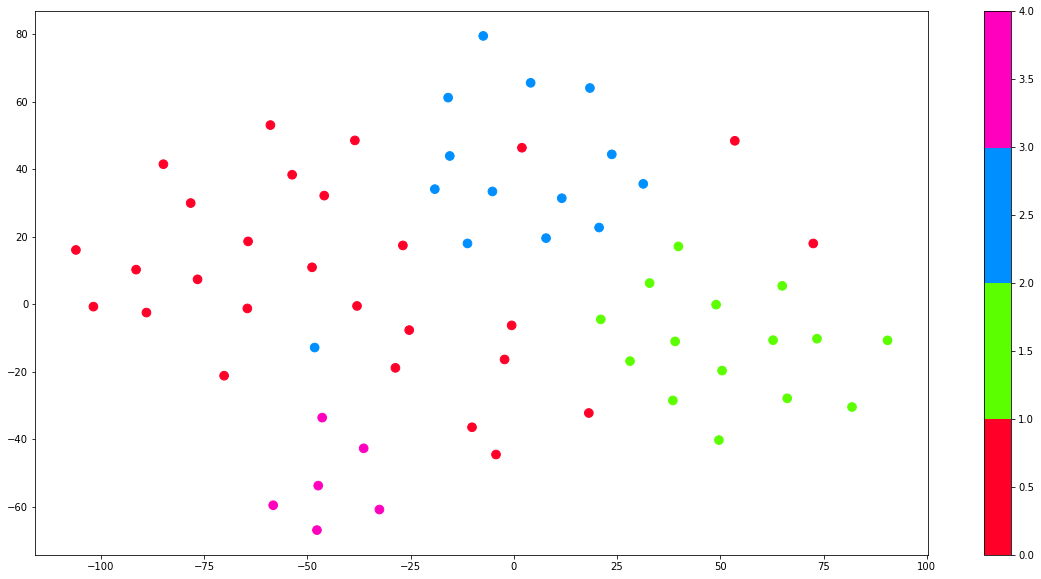

In [79]:
###Visualize
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embeddings_PCA)
#print(cluster_assignment)
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
#outliers = result.loc[result.labels == -1, :]
#clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster_assignment, vmin = 0, vmax = cols,  s=75, cmap=custom_cmap)
plt.colorbar()
plt.show()

Cluster keywords

In [85]:
for i, cluster in clustered_sentences.items():
    words = {}
    for s in cluster:
        lemmas = [y.lemma_ for y in nlp(s) if not y.is_stop and y.pos_ != 'PUNCT']
        for w in lemmas:
            try:
                words[w] += 1
            except Exception as e:
                words[w] = 1

    indices = np.argsort(list(words.values())).astype(int)
    keys_ = list(words.keys())
    #print(list(words.keys()))
    keywords = [keys_[int(ind)] for ind in indices[-5:]]
        
    print("Cluster ", i+1, "has keywords: ", keywords)
    print("")





Cluster  4 has keywords:  ['harassment', 'worker', 'movement', 'Apple', 'fire']

Cluster  1 has keywords:  ['sell', 'apple', 'Jones', 'Dow', 'Apple']

Cluster  3 has keywords:  ['Pro', 'chip', 'M1', 'new', 'Apple']

Cluster  2 has keywords:  ['launch', 'chip', 'AirPods', 'new', 'Apple']

